# Image Processing SoSe 22 - Assignment - 07

### Deadline is 16.06.2022 at 11:55am

Please solve the assignments together with a partner.
I will run every notebook. Make sure the code runs through. Select `Kernel` -> `Restart & Run All` to test it.

In [20]:
# display the plots inside the notebook
%matplotlib inline

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
from skimage.data import chelsea
from skimage.color import rgb2gray
import cmath
import math
    
from numpy.fft import fft2 as numpy_fft2, ifft2 as numpy_ifft2

pylab.rcParams['figure.figsize'] = (12, 12)   # This makes the plot bigger

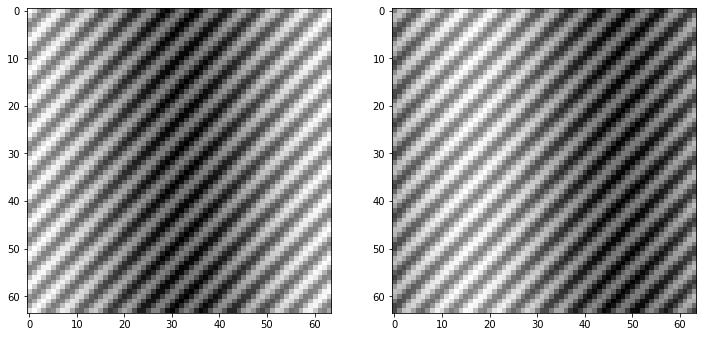

In [22]:
# Playground to get some intuition for 2d fourier transformation
ft = np.zeros((64,64))

# set some random coefficents and see what happens
ft[0, 1] = 1
ft[10, 10] = 1

plt.subplot(121)
plt.imshow(np.real(numpy_ifft2(ft)), cmap='gray')
plt.subplot(122)
plt.imshow(np.imag(numpy_ifft2(ft)), cmap='gray')
plt.show()

# Exercise 1 - 2D DFT - 2 Points
Implement the 2D Discrete Fourier Transformation with [Matrix Multiplication](https://en.wikipedia.org/wiki/DFT_matrix). You can use your code from the last assignment to compute the dft matrix.

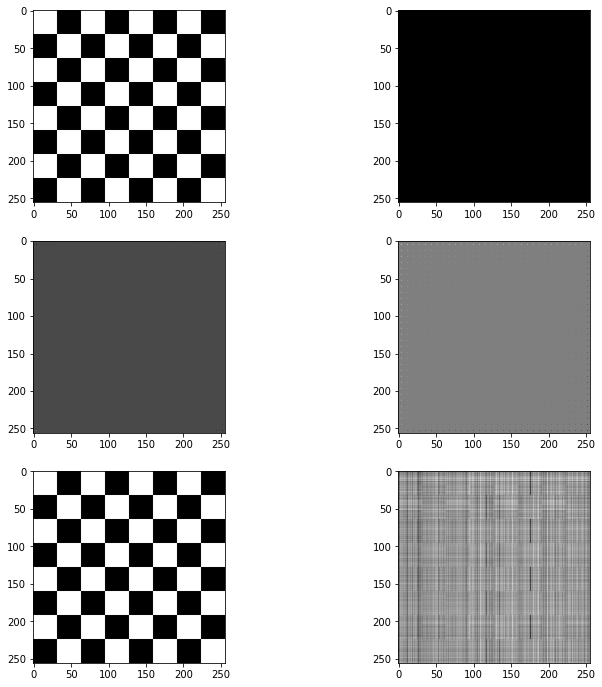

In [23]:
def dft_matrix(n):
    """
    Returns the Discrete Fourier Transformation Matrix of order `n`.
    """
    w = cmath.exp((2 * cmath.pi * 1j) / n)
    W = np.zeros((n,n),dtype=complex)
    for i in range(n):
        for k in range(n):
            W[i][k] = (1/cmath.sqrt(n)) * (w**(i*k))
    return W

def dft2d(img):
    """
    Returns the 2d discrete fourier transformation
    """
    N=img.shape[0]
    dft_mat = dft_matrix(N)
    dft_img = np.matmul(dft_mat,img)
    dft_img = np.matmul(dft_img,dft_mat)
    return dft_img

def inv_dft2d(img):
    """
    Returns the 2d inverse discrete fourier transformation
    """
    N=img.shape[0]
    dft_mat = np.linalg.inv(dft_matrix(N))
    dft_img = np.matmul(dft_mat,img)
    dft_img = np.matmul(dft_img,dft_mat)
    return dft_img


def chess_board(n=8, field_size=32):
    board = np.zeros((n*field_size, n*field_size))
    s = field_size
    for i in range(n):
        for j in range(n):
            if (i + j) % 2 == 0:
                board[i*s:(i+1)*s, j*s:(j+1)*s] = 1
    return board

plt.subplot(321)
plt.imshow(np.real(chess_board()), cmap='gray')
plt.subplot(322)
plt.imshow(np.imag(chess_board()), cmap='gray')
plt.subplot(323)
plt.imshow(np.real(dft2d(chess_board())), cmap='gray')
plt.subplot(324)
plt.imshow(np.imag(dft2d(chess_board())), cmap='gray')
plt.subplot(325)
plt.imshow(np.real(inv_dft2d(dft2d(chess_board()))), cmap='gray')
plt.subplot(326)
plt.imshow(np.imag(inv_dft2d(dft2d(chess_board()))), cmap='gray')
plt.show()

# Exercise 2 - High and Low Pass filter with the 2D fourier transformation - 3 Points

In [24]:
def high_pass(img_ft, n):
    """Removes the low frequencies"""
    ft = img_ft.copy()
    ft[:n, :n] = 0
    ft[-n:, :n] = 0
    ft[-n:, -n:] = 0
    ft[:n, -n:] = 0
    return ft

def low_pass(img_ft, n):
    """Removes the high frequencies"""
    ft = img_ft.copy()
    ft[n:-n, :] = 0
    ft[:, n:-n] = 0
    return ft
    
def band_pass(img_ft, low, high):
    """Only preserve the frequencies between low and high"""
    ft_high = high_pass(img_ft,low)
    ft = low_pass(ft_high,high)
    return ft
    
def inv_dft_and_plot(img_ft):
    plt.imshow(np.real(numpy_ifft2(img_ft)), cmap='gray')
    plt.show()

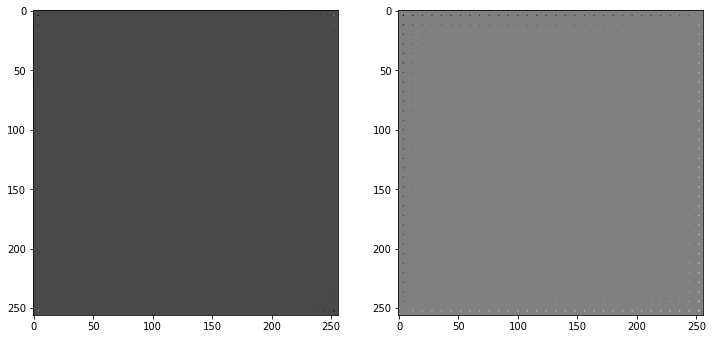

In [25]:
chess_board_ft = numpy_fft2(chess_board())

# display frequency domain of the chess_board
plt.subplot(121)
plt.imshow(np.real(chess_board_ft), cmap='gray')
plt.subplot(122)
plt.imshow(np.imag(chess_board_ft), cmap='gray')
plt.show()

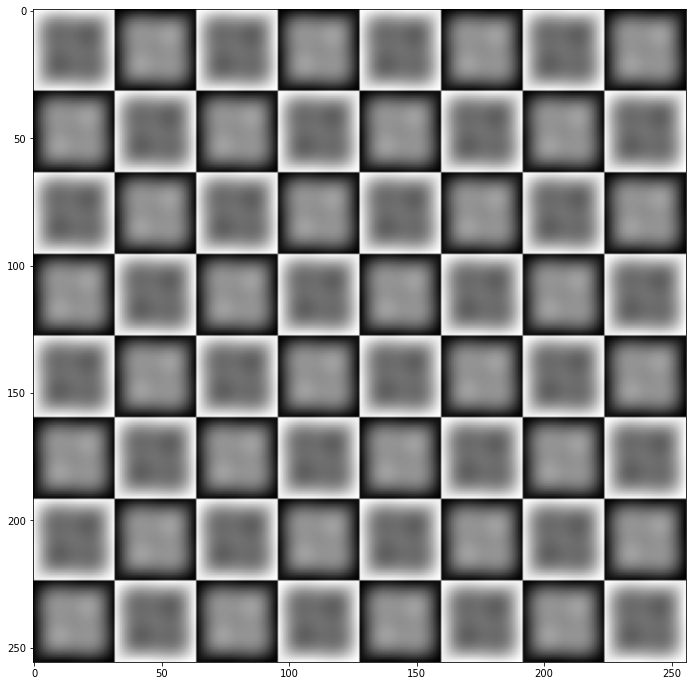

In [26]:
# remove the low frequencies of the chess board
chess_high_feq = high_pass(chess_board_ft, 12)
inv_dft_and_plot(chess_high_feq)

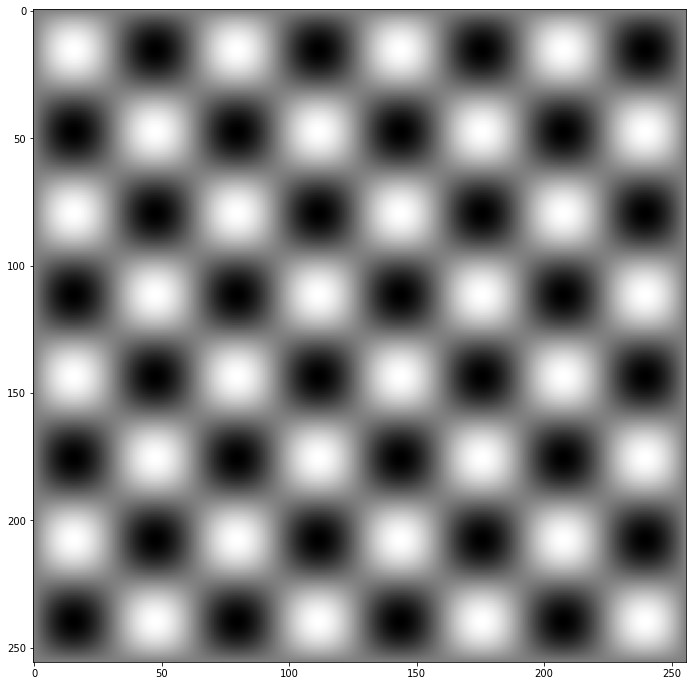

In [27]:
# remove the high frequencies of the chess board
chess_low_feq = low_pass(chess_board_ft, 10)
inv_dft_and_plot(chess_low_feq)

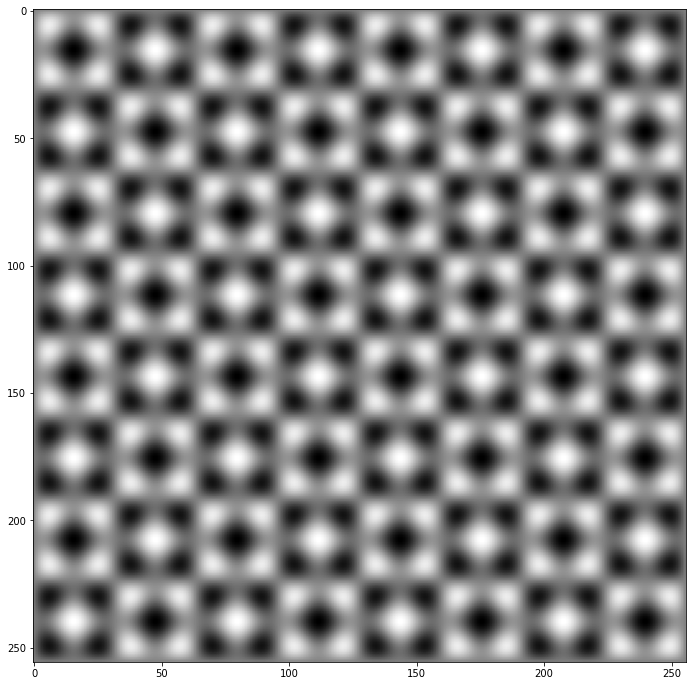

In [28]:
# remove the high frequencies of the chess board
chess_medium_feq = band_pass(chess_board_ft, 5, 15)
inv_dft_and_plot(chess_medium_feq)

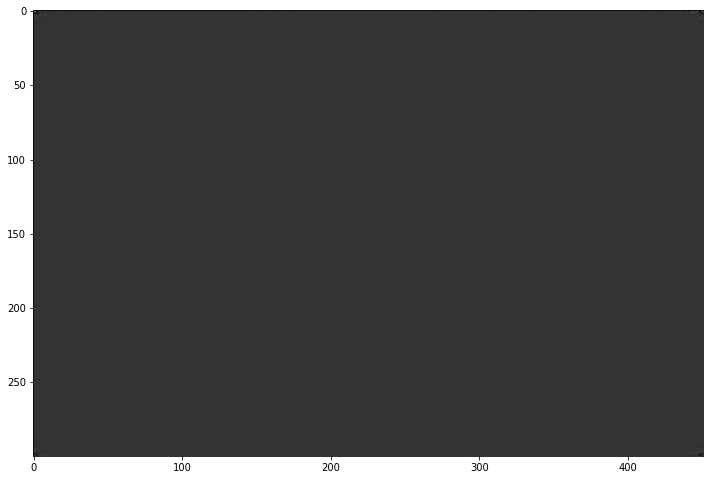

In [29]:
img = rgb2gray(chelsea() / 255)
# filter all frequencies corresponding to the coefficients between 48 and 128. <- Diesen Satz verstehe ich nicht.

img = band_pass(img, 48, 128) # Das ist sicherlich nicht gemeint, aber was?

inv_dft_and_plot(img)

# Exercise 3 - FFT - 5 Points

Implement the fast fourier transformation. 
Use the [Cooley-Tukey](https://en.wikipedia.org/wiki/Cooley%E2%80%93Tukey_FFT_algorithm) algorithm.

In [30]:
def fft(x):
    """
    Computes the fast fourier transformation of x.
    """
    N_v = x.shape[0]
    M_v = x.shape[1]
    N = max(x.shape[0], x.shape[1])
    for i in range(int(N/2)):
        if (2**i)==N and N_v==M_v:
            break
        elif (2**i)>=N:
            N = 2**i
            x_new = np.zeros((N,N),dtype=complex)
            x_new[:int(N_v),:int(M_v)] = x
            x = x_new
            break
    X = np.zeros((N,N),dtype= 'complex_')
    for i in range(N):
        X[i] = fft_help(x[i],N,1)
    Y = np.zeros((N,N),dtype= 'complex_')
    for i in range(N):
        Y[:,i] = fft_help(X[:,i],N,1)
    return Y

def fft_help(x, N, s):
    X=np.zeros(int(N),dtype= 'complex_')
    if N == 1:
        X[0] = x[0]
    else:
        X1 = fft_help(x,N/2,2*s)
        X2 = fft_help(x[s:],N/2,2*s)
        X = np.concatenate((X1,X2))
        for k in range(int(N/2)):
            p = X[k]
            q = cmath.exp((((-2) * cmath.pi * 1j) / N)*k) * X[k+int(N/2)]
            X[k] = p+q
            X[k+int(N/2)] = p-q
    return X


In [31]:
img = rgb2gray(chelsea() / 255)
fft_img = fft(img)

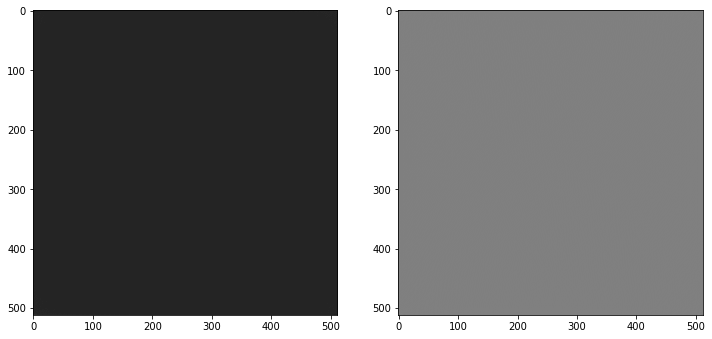

In [32]:
plt.subplot(121)
plt.imshow(np.real(fft_img), cmap="gray")
plt.subplot(122)
plt.imshow(np.imag(fft_img), cmap="gray")
plt.show()

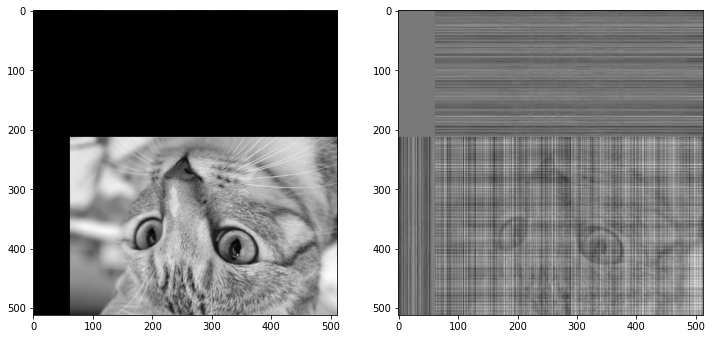

In [33]:
plt.subplot(121)
plt.imshow(np.real(inv_dft2d(fft_img)),cmap="gray")
plt.subplot(122)
plt.imshow(np.imag(inv_dft2d(fft_img)),cmap="gray")
plt.show() #obviously not really the right outcome here, but i cannot figure out where it went wrong...